## Train model to cycle at 1 frequency. Learn two new cycling speeds with a context signal and a change in reward contingency
    - Use backprop to train rate network,
    - Use FORCE to train Brian network to generate the latents
    - Use reward-based learning to change network behavior.

In [1]:
# import stuff
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.fft import fft,fftfreq
import datetime
import scipy
import pickle

In [89]:
# define a simple network composed of recurrent J weights and a single linear readout
class cyclingRNN(nn.Module):
    def __init__(self, nneurons: int = 200, save_path: str = None, lr: float =1e-3,
                 device: torch.device = None, dt: float=0.01, tau: float = 0.1):
        super().__init__()

        # will almost always want to use the CPU to train
        if device is None:
            self.device = torch.device('cpu')
            device = self.device
        else:
            self.device = device

        # initialize all of our weights and set a few parameters
        J_mat = (1.2 * np.random.randn(nneurons, nneurons)/np.sqrt(nneurons))
        self.J = nn.Parameter(torch.from_numpy(J_mat.astype(np.float32)).to(device))
        self.Wout = nn.Parameter(torch.from_numpy((np.random.randn(1, nneurons)/np.sqrt(nneurons)).astype(np.float32)).to(device))
        self.Win  = nn.Parameter(torch.from_numpy((np.random.randn(nneurons,1)/np.sqrt(nneurons)).astype(np.float32)).to(device))
        self.neural_nonlinearity = nn.Tanh()
        self.dt = dt
        self.tau = tau
        self.opt = torch.optim.Adam(self.parameters(), lr=lr)
        self.save_path = save_path
        self.movement_time_range = [0.1,6]
        self.input_on_time_range = [1,3]
        self.output_delay = tau * 1
        self.Loss = []
        self.rates = None
        #self.create_targets_and_inputs()
        self.output = None
        self.inputs = None
        self.batch_size = 1
        self.initialState = torch.randn((self.J.shape[0], self.batch_size), device=device) / np.sqrt(self.J.shape[0])

    def create_targets_and_inputs(self, frequencies=None, amplitude: int = 1):

        if frequencies is None:
            frequencies = [1]

        # choose a random time for the input to go high (start movement)
        start_idx = np.random.randint(low=int(self.input_on_time_range[0]/self.dt),high=int(self.input_on_time_range[1]/self.dt))

        # index where the output starts
        movement_start_idx = start_idx + int(self.output_delay / self.dt)

        # choose a movement duration for this trial
        move_duration =  np.diff(self.movement_time_range)[0] * np.random.random() + self.movement_time_range[0]

        # calculate the total trial duration
        trial_time = move_duration + (movement_start_idx*self.dt)

        # duration of trial (in samples)
        trl_l = int(trial_time / self.dt) + 1

        # time vector (will be useful for creating targets)
        movement_times = np.arange(0,move_duration,self.dt)

        # define our input vectors
        inputs = np.zeros((trl_l,len(frequencies))) + (np.arange(len(frequencies))+1)

        # make the inputs turn on at startIdx
        inputs[:start_idx,:] = 0

        # define our outputs
        targets = np.zeros((trl_l,len(frequencies)))
        for ii in range(len(frequencies)):
            targets[movement_start_idx:,ii] = amplitude * np.sin(movement_times * (frequencies[ii] * 2 * np.pi))

        self.Targets = targets
        self.Inputs  = inputs

    def forward(self, targets: np.ndarray = None, inputs: np.ndarray = None, trial_length: int = None, noise_scale: float = 1e-6):
        device = self.device
        batch_size = 1
        Targets = torch.from_numpy(targets.astype(np.float32))
        Inputs = torch.from_numpy(inputs.astype(np.float32))
        position_store = torch.zeros(int(trial_length), batch_size)
        rates = torch.zeros(int(trial_length),self.initialState.shape[0],batch_size)

        # cycle through trials
        for trl in range(batch_size):

            xm1 = self.initialState
            rm1 = self.neural_nonlinearity(xm1)


            for idx in np.arange(0,trial_length):
                xm1 = xm1 + self.dt/self.tau * (-xm1 + (self.J @ rm1 + (Inputs[idx,trl] * self.Win) +
                                            torch.randn(rm1.shape, device=device) * np.sqrt(noise_scale)))
                rm1 = self.neural_nonlinearity(xm1)
                position_store[idx,trl] = (self.Wout @ rm1)[0][0]
                rates[idx,:,trl] = rm1[:,0]

        # average loss over time
        loss = ((Targets[:,0] - position_store[:,0])**2).mean()

        self.output = position_store
        self.rates  = rates
        self.inputs = inputs
        return loss


    def fit_initial_m1(self, trials: int = 1500):
        m1_params = [self.J, self.Wout, self.Win]
        optimizer = torch.optim.Adam(m1_params, lr=1e-3)
        for trial in range(trials):
            optimizer.zero_grad()
            self.create_targets_and_inputs()
            targets = self.Targets
            inputs  = self.Inputs
            loss = self.forward(targets = targets,inputs = inputs,trial_length = targets.shape[0])
            self.Loss.append(loss.item())
            loss.backward()
            optimizer.step()


    # return inputs, rates, targets, outputs, without any noise
    def returnRates(self, start_idx: int=200,move_duration: float=6.0):

        device = self.device

        # generate our inputs
        frequencies = [1]

        # index where the output starts
        movement_start_idx = start_idx + int(self.output_delay / self.dt)

        # calculate the total trial duration
        trial_time = move_duration + (movement_start_idx*self.dt)

        # duration of trial (in samples)
        trl_l = int(trial_time / self.dt)

        # time vector (will be useful for creating targets)
        movement_times = np.arange(0,move_duration,self.dt)

        # define our input vectors
        inputs = np.zeros((trl_l,len(frequencies))) + (np.arange(len(frequencies))+1)

        # make the inputs turn on at startIdx
        inputs[:start_idx,:] = 0

        # convert to tensor
        Inputs = torch.from_numpy(inputs.astype(np.float32))

        # define our outputs
        targets = np.zeros((trl_l,len(frequencies)))
        amplitude=1
        for ii in range(len(frequencies)):
            targets[movement_start_idx:,ii] = amplitude * np.sin(movement_times * (frequencies[ii] * 2 * np.pi))

        # run the model forward
        numNeurons = self.initialState.shape[0]

        # rates are T x N x C
        rates = np.zeros((trl_l,numNeurons,1))

        # output is T x C
        output = np.zeros((trl_l,1))

        # set the noise scale
        noise_scale = 1e-4

        # cycle through conditions
        for trl in range(1):

            xm1 = self.initialState
            rm1 = self.neural_nonlinearity(xm1)

            for idx in np.arange(0,trl_l):
                xm1 = xm1 + self.dt/self.tau * (-xm1 + (self.J @ rm1 + (Inputs[idx,trl] * self.Win) +
                                            torch.randn(rm1.shape, device=device) * np.sqrt(noise_scale)))
                rm1 = self.neural_nonlinearity(xm1)
                rates[idx,:,trl] = rm1.detach().numpy()[:,0]
                output[idx,trl]  = (self.Wout @ rm1).detach().numpy()[0][0]


        return inputs, targets, output, rates


### Train the model with backprop

In [90]:
# initialize and fit the model
model = cyclingRNN()
model.fit_initial_m1()

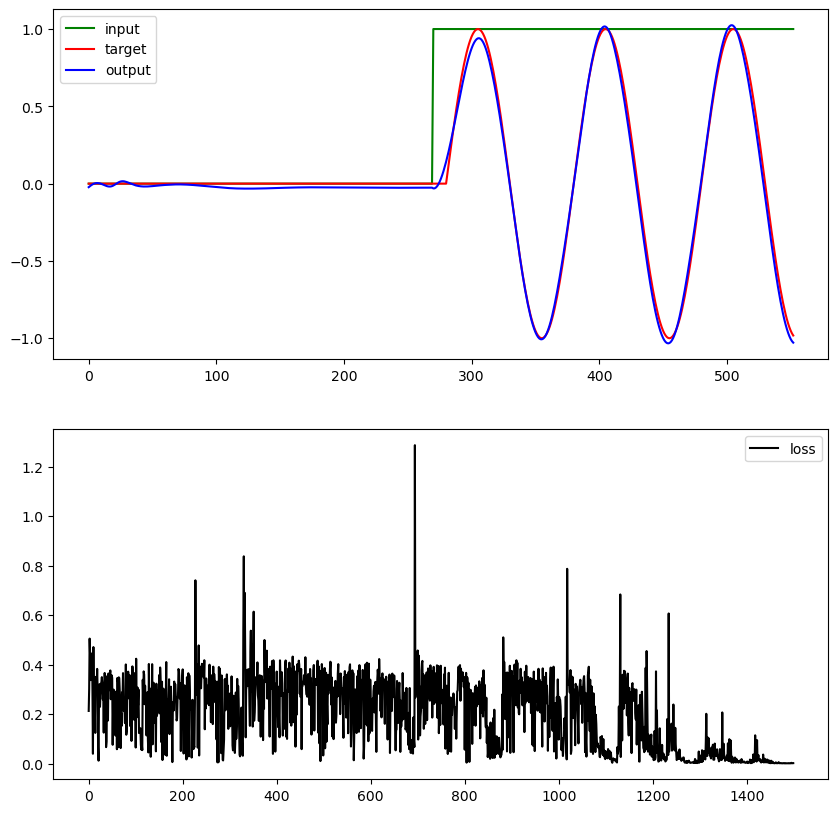

In [91]:
# plot the final output and the loss over training
modelOutput = model.output.detach().numpy()
target = model.Targets
input = model.Inputs
loss = model.Loss
plt.figure(figsize=(10,10))
for ii in range(1):

    plt.subplot(2,1,ii+1);
    plt.plot(input[:,ii],'g',label = 'input')
    plt.plot(target[:,ii],'r',label = 'target');
    plt.plot(modelOutput[:,ii],'b',label='output');
    if ii == 0:
        plt.legend();

plt.subplot(2,1,2);
plt.plot(loss,'k',label='loss');
plt.legend();


In [92]:
# save the model
savePath = '/Users/andrew/Documents/GitHub/basal_ganglia/networks/trainedModels/multiSpeedLearning/'

# get current time
ct = str(datetime.datetime.now())[:19]

# replace colons with an underscore
ct = ct.replace(':','_')

# set up the path and dictionary
savePath = savePath
state_dict = model.state_dict()
data_dict = {'model_state': state_dict, 'full_model': model}

# save
np.save(savePath + ct + '.npy',data_dict)

In [93]:
# return the rates (and inputs, targets, and outputs)
# rates are T x N x C
inputs, targets, output, rates = model.returnRates()

# pull out some useful numbers
trialDur, numN, numC = rates.shape


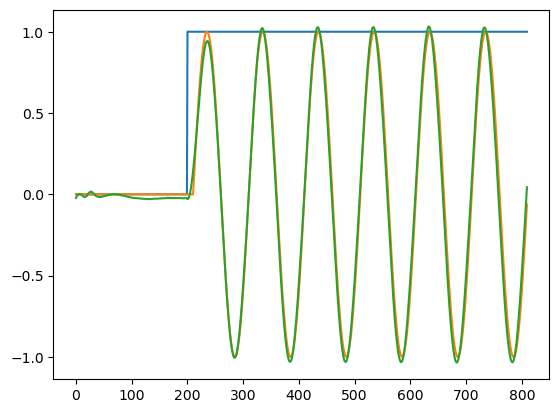

In [94]:
plt.plot(inputs[:,0]);
plt.plot(targets[:,0]);
plt.plot(output[:,0]);

four dimensions explain 0.9839377438093688 percent of total variance
ten dimensions explain 0.9993799589575217 percent of total variance


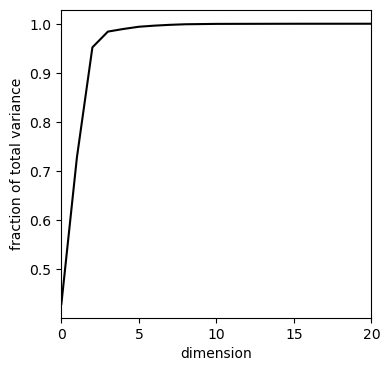

In [95]:
# run pca on the rates and extract the top K factors

# turn rates into a CT x N matrix
rates_rs = rates.transpose(0,2,1).reshape(-1,numN,order='F')

pca = PCA(n_components=numN)
proj = pca.fit_transform(rates_rs)

# generate a scree plot
varExp = pca.explained_variance_ratio_
plt.figure(figsize=(4,4))
plt.plot(np.cumsum(varExp),'k')
plt.ylabel('fraction of total variance');
plt.xlabel('dimension');
plt.xlim([0,20]);

# print some useful values
print('four dimensions explain ' + str(np.sum(varExp[:4])) + ' percent of total variance');
print('ten dimensions explain ' + str(np.sum(varExp[:10])) + ' percent of total variance');

### Train a second model to generate Z

In [153]:
### Train W weights using RLS ###
# fix W_in (taken from the rate model above), choose U randomly

# We're also going to feed in a static context signal. For now, this signal will just vary between -1 and 1, and the network should ignore it (generate the same output regardless of the magnitude of the context signal).


## define a few parameters ##

# define the input range
contextRange = [-1, 1]

# network time constant (in msec)
tau = 10

# gain for U weights
g_U = 0.1

# U weights are drawn from a uniform distribution. Set range of this distribution
uMin = -1
uMax = 1

# gain for the input weights
g_W_in = 0.1

# gain for J0 weights. We want these to be fairly small.
g_j0 = 0.5

# gain for initial W weights
g_w  = 0.025

# initial learning rate
alpha = 1

# number of latents
# the first K-1 latents will be taken from the rate model, and the last latent will just be the static context signal
numZ = 6

## draw our U and J0 weights ##

# U first
U = np.random.uniform(low=uMin,high=uMax, size=(numZ,numN)) * g_U

# J0
J0 = np.random.normal(loc=0, scale=(g_j0**2)/(numN * tau**2), size=(numN,numN))

# W_in
#W_in = model.Win.detach().numpy()
W_in = np.random.uniform(low=uMin,high=uMax, size=(numN,2)) * g_W_in

## define our target latents, Z ##
Z_target = proj[:,:(numZ-1)]

# reshape to be T x C x K
Z_target_rs = Z_target.reshape(-1,numC,(numZ-1),order='F').transpose(0,2,1)

# add a column of zeros to the target that will be filled in each trial
Z_target_rs = np.concatenate((Z_target_rs,np.zeros((Z_target_rs.shape[0],1,1))),axis=1)

## rename our inputs ##
INPUT = np.copy(inputs)

## number of trials to train ##
numTrials = 500

## trial duration ##
trlDur = rates.shape[0]

## initialize W ##
W = np.random.normal(loc=0,scale=1/(numN * g_w),size=(numN,numZ))

## initial state, x0 ##
x0 = np.random.normal(loc=0, scale=1,size=(numN,1)) / np.sqrt(numN)

## initial rate, r0 ##
r0 = np.zeros((numN,1))

## initial latents, z0 ##
z0 = np.zeros((numZ,1))

## initial value of P ##
P = np.eye(numN) / alpha

## scale of the training noise ##
noiseScale = 1e-7


In [154]:
# cycle through trials

# initialize an array to hold output
networkOutput = np.zeros((trlDur,numZ,numC,numTrials))

for trl in range(numTrials):

    # cycle through conditions
    for cc in range(numC):

        # set the initial state, rate, and latent
        x = np.copy(x0)
        r = np.copy(r0)
        z = np.copy(z0)

        # append a static context signal to our input
        ctxInput = np.zeros((trlDur,1)) + (2 * np.random.rand() -1)
        trlInput = np.concatenate((np.copy(INPUT),ctxInput),axis=1)

        # and add the same context input to the target
        Z_target_rs[:,-1,:] = ctxInput

        # cycle through the trial
        for ii in range(trlDur):

            # update our state
            x += (1/tau) * (-x + (J0.T@r) + (U.T@z) + (W_in @ np.atleast_2d(trlInput[ii,:]).T)
                            + np.random.normal(loc = 0, scale = np.sqrt(noiseScale), size = x.shape))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = W.T@r

            # save the output
            networkOutput[ii,:,cc,trl] = z[:,0]

            # calculate the error
            error = np.atleast_2d(z[:,0] - Z_target_rs[ii,:,cc])

            # update the weights
            W = W - ((P @ r)@error)

            # update P
            P = P - ((P @ r @ r.T @ P)/(1 + (r.T @ P @ r)))


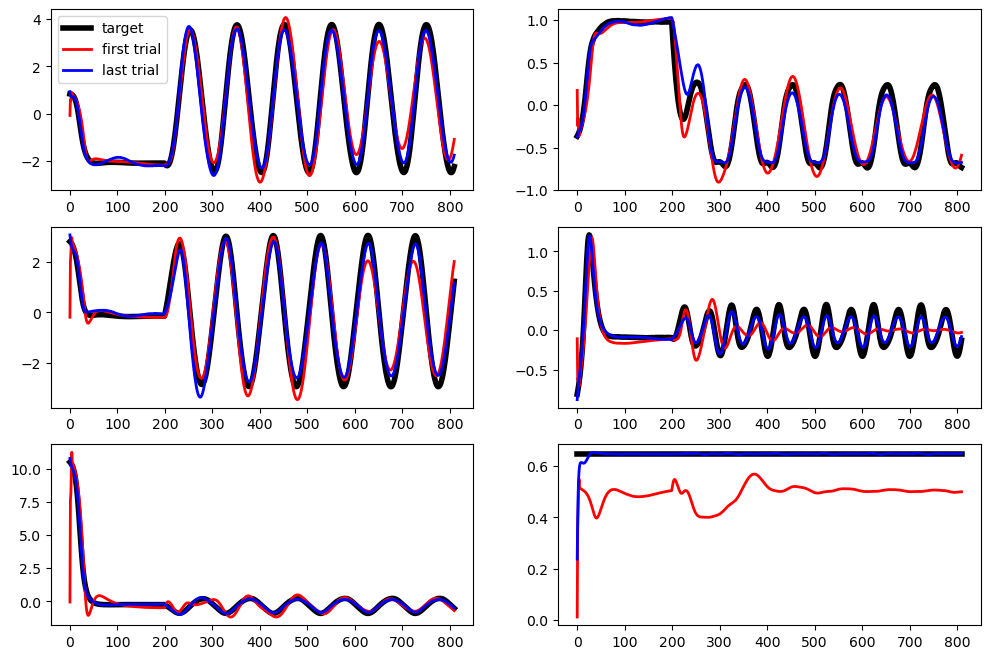

In [155]:
# plot the first and last trial (along with the target)
numRows = int(numZ/2)
fig, ax = plt.subplots(numRows,2, figsize = (12,8))

# only plot 1 condition
cond = 0

for ii in range(numZ):

    # get the row and column index
    rIdx = np.mod(ii,numRows)
    cIdx = (ii//numRows)

    # plot the target
    ax[rIdx,cIdx].plot(Z_target_rs[:,ii,cond],'k',linewidth=4,label='target');

    # plot the first trial
    ax[rIdx,cIdx].plot(networkOutput[:,ii,cond,0],'r',linewidth=2,label='first trial')

    # plot the last trial
    ax[rIdx,cIdx].plot(networkOutput[:,ii,cond,-1],'b',linewidth=2,label='last trial')



    if ii==0:
        ax[rIdx,cIdx].legend()


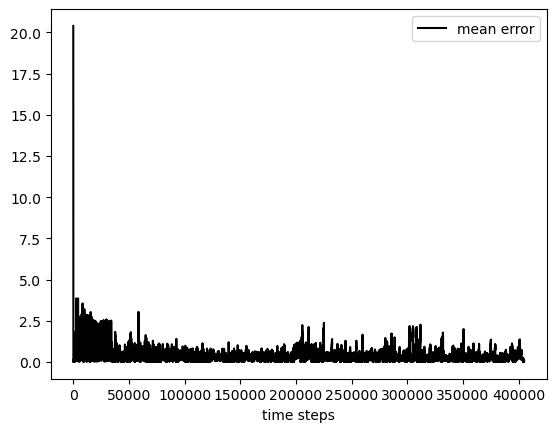

In [156]:
# plot error (averaged over output dimensions) as a function of training steps
meanError = ((networkOutput - np.tile(Z_target_rs[:,:,:,np.newaxis], (1,1,1,numTrials)))**2).mean(axis=1).squeeze()

# reshape to be size (T x Trl) x 1
meanError_rs = np.reshape(meanError,(-1,1),order='F')

# plot
plt.plot(meanError_rs[:,0],'k',label='mean error');
plt.legend();
plt.xlabel('time steps');
# plt.ylabel('error');

In [157]:
# save the FORCE weights
# use the same timestamp as above
data_dict = {'J0': J0, 'U': U,'W': W, 'W_in': W_in,
             'x0': x0, 'r0': r0, 'z0': z0,
             'Z_target': Z_target, 'INPUT': INPUT}
np.save(savePath + ct + 'FORCE_network.npy',data_dict)

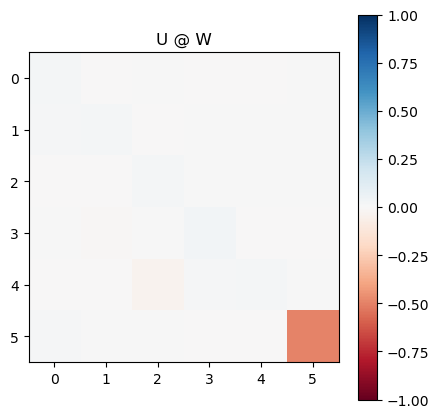

In [183]:
##  how orthogonal are U and W? ##

# normalize columns of W and (rows of) U to unity
W_norm = W / np.linalg.norm(W,axis=0)
U_norm = (U.T / np.linalg.norm(U.T,axis=0)).T

# calculate product of U and W
plt.figure(figsize=(5,5))
plt.imshow(U_norm@W_norm,cmap='RdBu',vmin=-1,vmax=1);plt.colorbar();
plt.title('U @ W');


### Plug in a B
    - B will allow us to readout the target (for the rate network) from the activity of the units
    - B will be orthogonal-ish to W

In [561]:
# function for getting the rates from the trained network
def returnRates(u,ipt,b=None,ctxMag = 0.5,xStart = None, rStart = None, zStart = None):

    ## initialize arrays to track rates and (if we are given a b) output of the network ##

    # useful numbers
    trlDuration = ipt.shape[0]
    numConds = 1
    numLatents,numUnits = u.shape

    # add the context input
    ctxInput = np.zeros((trlDuration,1)) + ctxMag
    ipt = np.concatenate((ipt,ctxInput),axis=1)

    # initialize our matrices
    allActivations = np.zeros((trlDuration, numConds, numUnits))
    allRates       = np.zeros((trlDuration, numConds, numUnits))
    allLatents     = np.zeros((trlDuration, numConds, numLatents))
    allOutputs     = np.zeros((trlDuration,numConds))


    # cycle through conditions
    for cc in range(numConds):

        # set the inital states/rates/Z
        if xStart is None:
            x = np.copy(x0)
            r = np.copy(r0)
            z = np.copy(z0)
        else:
            x = np.copy(xStart)
            r = np.copy(rStart)
            z = np.copy(zStart)


        # cycle through time
        for ii in range(trlDuration):

            # update our state
            x += (1/tau) * (-x + (J0.T@r) + (u.T@z) + (W_in @ np.atleast_2d(ipt[ii,:]).T))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = W.T@r

            # save the activations
            allActivations[ii,cc,:] = x[:,0]

            # save the rates
            allRates[ii,cc,:] = r[:,0]

            # save the latents
            allLatents[ii,cc,:] = z[:,0]

            # if we have an output vector, save network output
            if b is not None:
                allOutputs[ii,cc] = b.T@r

    # return output
    return allActivations, allRates, allLatents, allOutputs

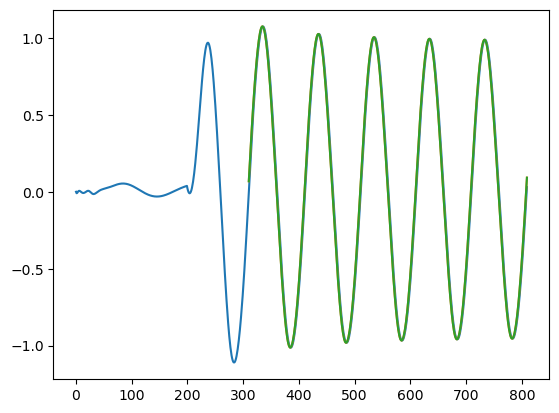

In [819]:
# pull out the activity, rates, and latents from a time when the network is already in a limit cycle
activations,rates,latents,out1 = returnRates(U,INPUT,B,ctxMag=0.5)
startIdx = 310
xStart = activations[startIdx,:,:].T
rStart = rates[startIdx,:,:].T
zStart = latents[startIdx,:,:].T
activations2,rates2,latents2,out2 = returnRates(U,INPUT[startIdx:,:],B,ctxMag=0.5,xStart=xStart,rStart=rStart,zStart=zStart)
activations3,rates3,latents3,out3 = returnRates(U,INPUT[startIdx:,:],B,ctxMag=0.5,xStart=xStart,rStart=rStart,zStart=zStart)

plt.plot(out1[:,0])
plt.plot(np.arange(startIdx,out1.shape[0]),out2[:,0])
plt.plot(np.arange(startIdx,out1.shape[0]),out3[:,0])

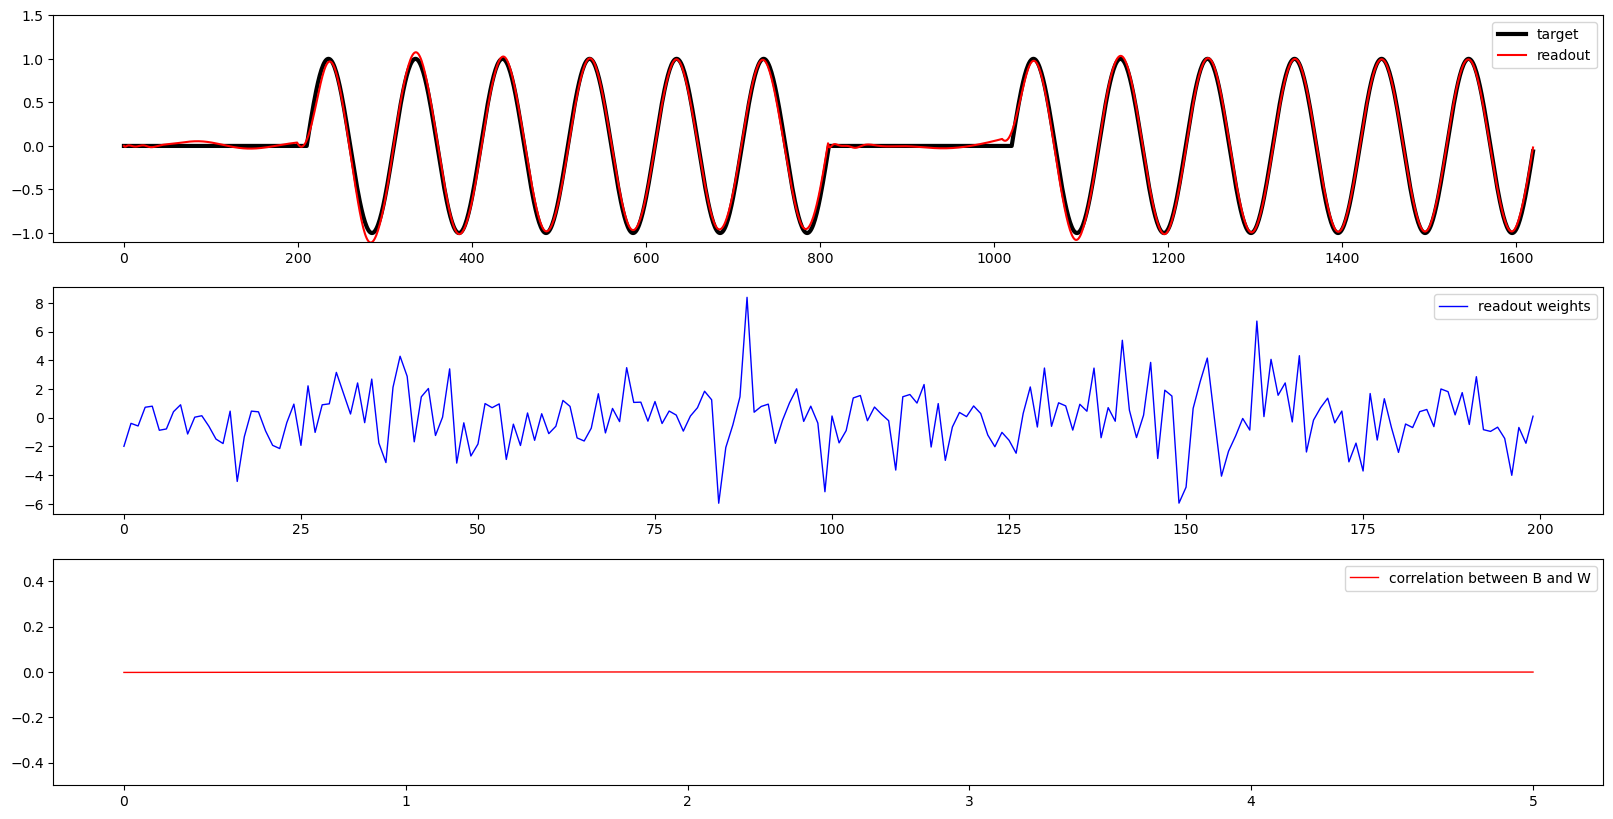

In [316]:
### use regression to define a B ##
# make B null to the top 'K' dimensions of W
numNullDims = 6

# get rates from the trained FORCE network

# regress using activity from 2 contexts
rates1,_,_ = returnRates(U,INPUT,ctxMag=0.5)
rates2,_,_ = returnRates(U,INPUT,ctxMag=-0.5)

# reshape to be CT x N
rates1_rs = rates1.reshape(-1,numN,order='F');
rates2_rs = rates2.reshape(-1,numN,order='F');

# concatenate
rates_rs = np.concatenate((rates1_rs,rates2_rs),axis=0)

# reshape the targets from our rate network
targets_rs = targets.reshape(-1,1,order='F')
targets_rs = np.tile(targets_rs,(2,1))

# define a regularization term
ridgeLambda = 1e-3

# define the null space of W, project rates into this space
W_null = scipy.linalg.null_space(W[:,:numNullDims].T)
rates_null = rates_rs@W_null

# regress
b_null = np.linalg.inv(rates_null.T @ rates_null + np.eye(rates_null.shape[1]) * ridgeLambda) @ rates_null.T @ targets_rs
B = W_null@b_null

# plot target and target_hat
yHat = rates_rs@B
plt.figure(figsize=(20,10))
plt.subplot(3,1,1);
plt.plot(targets_rs,'k',linewidth=3,label='target');
plt.plot(yHat,'r',label='readout');
plt.ylim([-1.1,1.5]);
plt.legend();

# plot B
plt.subplot(3,1,2);
plt.plot(B,'b',linewidth=1,label='readout weights');
plt.legend();

# calculate correlation between B and each column of W
plt.subplot(3,1,3);
bCorr = np.zeros(numZ) + np.nan
for ii in range(numZ):
    bCorr[ii] = np.corrcoef(B[:,0],W[:,ii])[0,1]
plt.plot(bCorr,'r',linewidth=1,label='correlation between B and W');
plt.ylim([-0.5,0.5]);
plt.legend();


### Verify that we can get 'useful' changes to the output with random changes to U.
    - apply random changes to U, measure change in frequency and change in adjusted MSE
    - adjusted MSE is the MSE after accounting for the change in frequency

In [921]:
# function for returning peak frequency of a 1d Trace
# FFT doesn't give me the resolution I want, so just make a bunch of waves at different frequencies and ask which one matches our signal best

def returnPeakFreq(signal, minFreq = 0.8, maxFreq = 1.2, numFreqs = 100):

    # length of our signal
    L = signal.shape[0]

    # time vector
    t = np.arange(L)

    # vector of frequencies to test
    freqs = np.linspace(minFreq,maxFreq,numFreqs)

    # vector to hold the dot product of our signal and the waves we make
    mags = np.zeros(numFreqs) + np.nan

    # cycle through all of our frequencies
    for idx,f in enumerate(freqs):

        # make our templates
        testSin = np.sin(f*0.01 * 2 * np.pi * t)
        testCos = np.cos(f*0.01 * 2 * np.pi * t)

        mags[idx] = np.dot(signal,testSin) + np.dot(signal,testCos)

    # return the frequency that matches best
    return freqs[np.argmax(mags)]

# function for returning the MSE between two traces, after one has been stretched to match the other.
def calculateAdjustedMSE(signal1, signal2, freq1, freq2):

    # duration of original signal
    oSignalDur = signal1.size

    # figure out which signal needs to be stretched
    if freq1 < freq2:
        slowSignal = signal1
        fastSignal = signal2
        slowFreq = freq1
        fastFreq = freq2
        stretchFlag = True
    elif freq2 < freq1:
        slowSignal = signal2
        fastSignal = signal1
        slowFreq = freq2
        fastFreq = freq1
        stretchFlag = True
    else:
        # if both signals have the same dominant frequency, no need to do any stretching
        slowSignal = signal1
        fastSignal = signal2
        stretchFlag = False

    if stretchFlag:

        # calculate the ratio of the fast signal to the slow signal
        freqRatio = fastFreq/slowFreq

        # generate a stretched time base for the faster signal
        fastTimes_stretched = np.arange(0,oSignalDur) * freqRatio

        # interpolate the faster signal to get a signal the same length as the slow signal
        fastSignal = np.interp(np.arange(0,oSignalDur),fastTimes_stretched,fastSignal)

    # now calculate the MSE
    return ((slowSignal - fastSignal)**2).mean()

In [950]:
# function for running perturbation experiment

# start rates at a time when the network is already in its limit cycle
def runPertExperiment(IN,numTrials=1000,pertMag = 1e-3):

    # first get the original (i.e., unperturbed) output
    _,_,_,originalOutput = returnRates(U,IN,B,xStart=xStart,rStart=rStart,zStart=zStart)

    # calculate the original frequency
    oFreq = returnPeakFreq(originalOutput[:,0])

    # keep track of our perturbations, change in frequency, and MSE
    allPerts = np.zeros((U.shape[0],U.shape[1],numTrials)) + np.nan
    dFreq    = np.zeros(numTrials) + np.nan
    MSE      = np.zeros(numTrials) + np.nan

    # calculate the norm of the original U (we want to make sure this doesn't change after the perturbation)
    U_norm = np.linalg.norm(U,axis=1)

    # cycle through perturbations
    for ii in range(numTrials):

        # generate a perturbation matrix for U.
        dU = 2 * np.random.random_sample(size=U.shape) -1

        # scale each row of U to have a magnitude of 'pertMag'
        dU = (dU.T/ np.linalg.norm(dU,axis=1)).T
        dU = dU * pertMag

        # only perturb the first K-1 dimensions
        dU[-1,:] = 0

        # generate our perturbed U
        U_pert = np.copy(U) + dU

        # re-normalize
        U_pert = (U_pert.T / np.linalg.norm(U_pert,axis=1)).T
        U_pert = U_pert * U_norm[:,np.newaxis]

        # save the perturbations
        allPerts[:,:,ii] = np.copy(U_pert)

        # generate a perturbed output
        _,_,_,newOutput = returnRates(U_pert,IN,B,xStart=xStart,rStart=rStart,zStart=zStart)

        # calculate the new frequency
        nFreq = returnPeakFreq(newOutput[:,0])

        # save change in frequency
        dFreq[ii] = oFreq - nFreq

        # calculate MSE
        MSE[ii] = calculateAdjustedMSE(originalOutput[:,0], newOutput[:,0], oFreq, nFreq)

    # return everything
    return allPerts, dFreq, MSE


In [951]:
# run the experiment

# make a longer input
longInput = np.ones((2000,1))
longInput[:200,:] = 0

# run experiment
allPerts, dFreq, MSE = runPertExperiment(longInput[startIdx:,:],numTrials=500,pertMag = 1e-3)

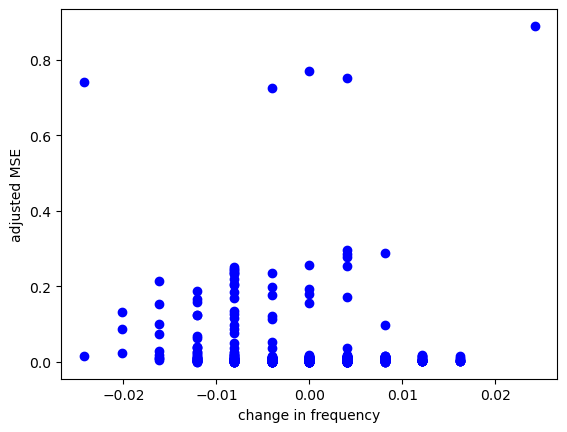

In [952]:
# plot everything
plt.plot(dFreq,MSE,'bo');
plt.xlabel('change in frequency');
plt.ylabel('adjusted MSE');


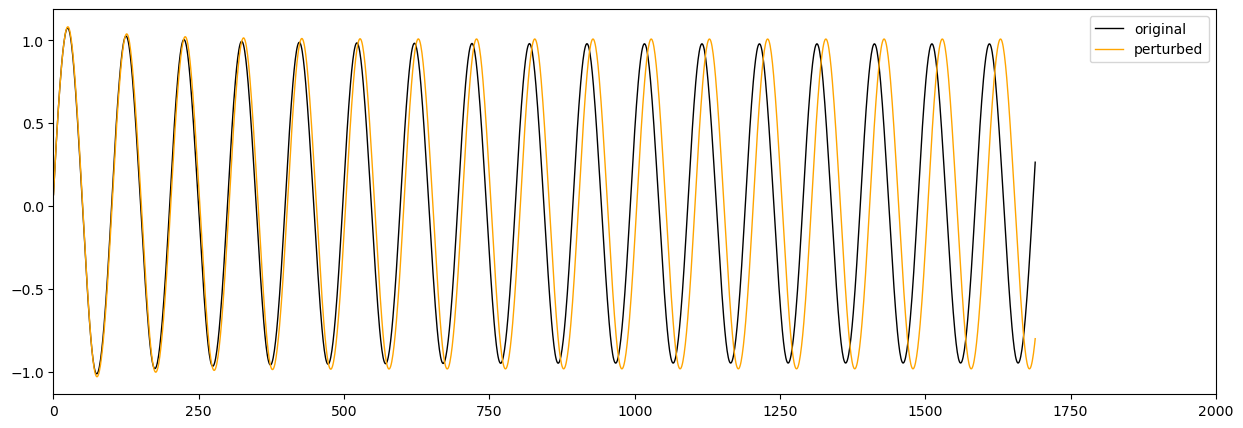

In [967]:
# plot an example perturbation with a large effect and small change in MSE

# original output
_,_,_,originalOutput = returnRates(U,longInput[startIdx:,:],B,xStart=xStart,rStart=rStart,zStart=zStart)

# choose a perturbation
pIdx = np.nonzero((MSE < 0.2) & (dFreq>0.01))[0][2]

# perturbed output
_,_,_,perturbedOutput = returnRates(allPerts[:,:,pIdx],longInput[startIdx:,:],B,xStart=xStart,rStart=rStart,zStart=zStart)

# plot
plt.figure(figsize=(15,5));
plt.plot(originalOutput[:,0],'k',linewidth=1,label='original')
plt.plot(perturbedOutput[:,0],'orange',linewidth=1,label='perturbed');

plt.legend()
plt.xlim([0,2000]);

In [624]:
##  explore the effects of perturbing one dimension of U ##

# randomly select 1 (1 x N) perturbation vector
dU_o = 2 * np.random.random_sample(size=(1,U.shape[1])) -1

# normalize to have magnitude of 1
dU_norm = (dU_o.T/ np.linalg.norm(dU_o,axis=1)).T

# generate perturbations of different magnitudes
# number of perturbations
numPerts = 8
pertMags = np.linspace(1e-5,5e-3,numPerts)

# generate our perturbations
dU = dU_norm * pertMags[:,np.newaxis]

# define an input for this experiment
input = np.ones((3000,1))
input[:200,:] = 0
input = input[startIdx:,:]

# get some useful numbers
trlDur = input.shape[0]

# number of dimensions we're perturbing
# (don't need to explore perturbations to the last dimension)
numDims = numZ - 1

# initialize an array to hold all of the outputs
allOutputs = np.zeros((trlDur,numDims,numPerts))

# cycle through dimensions
for dd in range(numDims):

    # cycle through perturbation magnitudes
    for pp in range(numPerts):

        # make our perturbed U
        U_pert = np.copy(U)
        U_pert[dd,:] = U_pert[dd,:] + dU[pp,:]

        # get output
        _,_,_,tempOutput = returnRates(U_pert,input,B,xStart=xStart,rStart=rStart,zStart=zStart)
        allOutputs[:,dd,pp] = tempOutput[:,0]

# as a comparison, apply the same perturbation to dimensions of U simultaneously

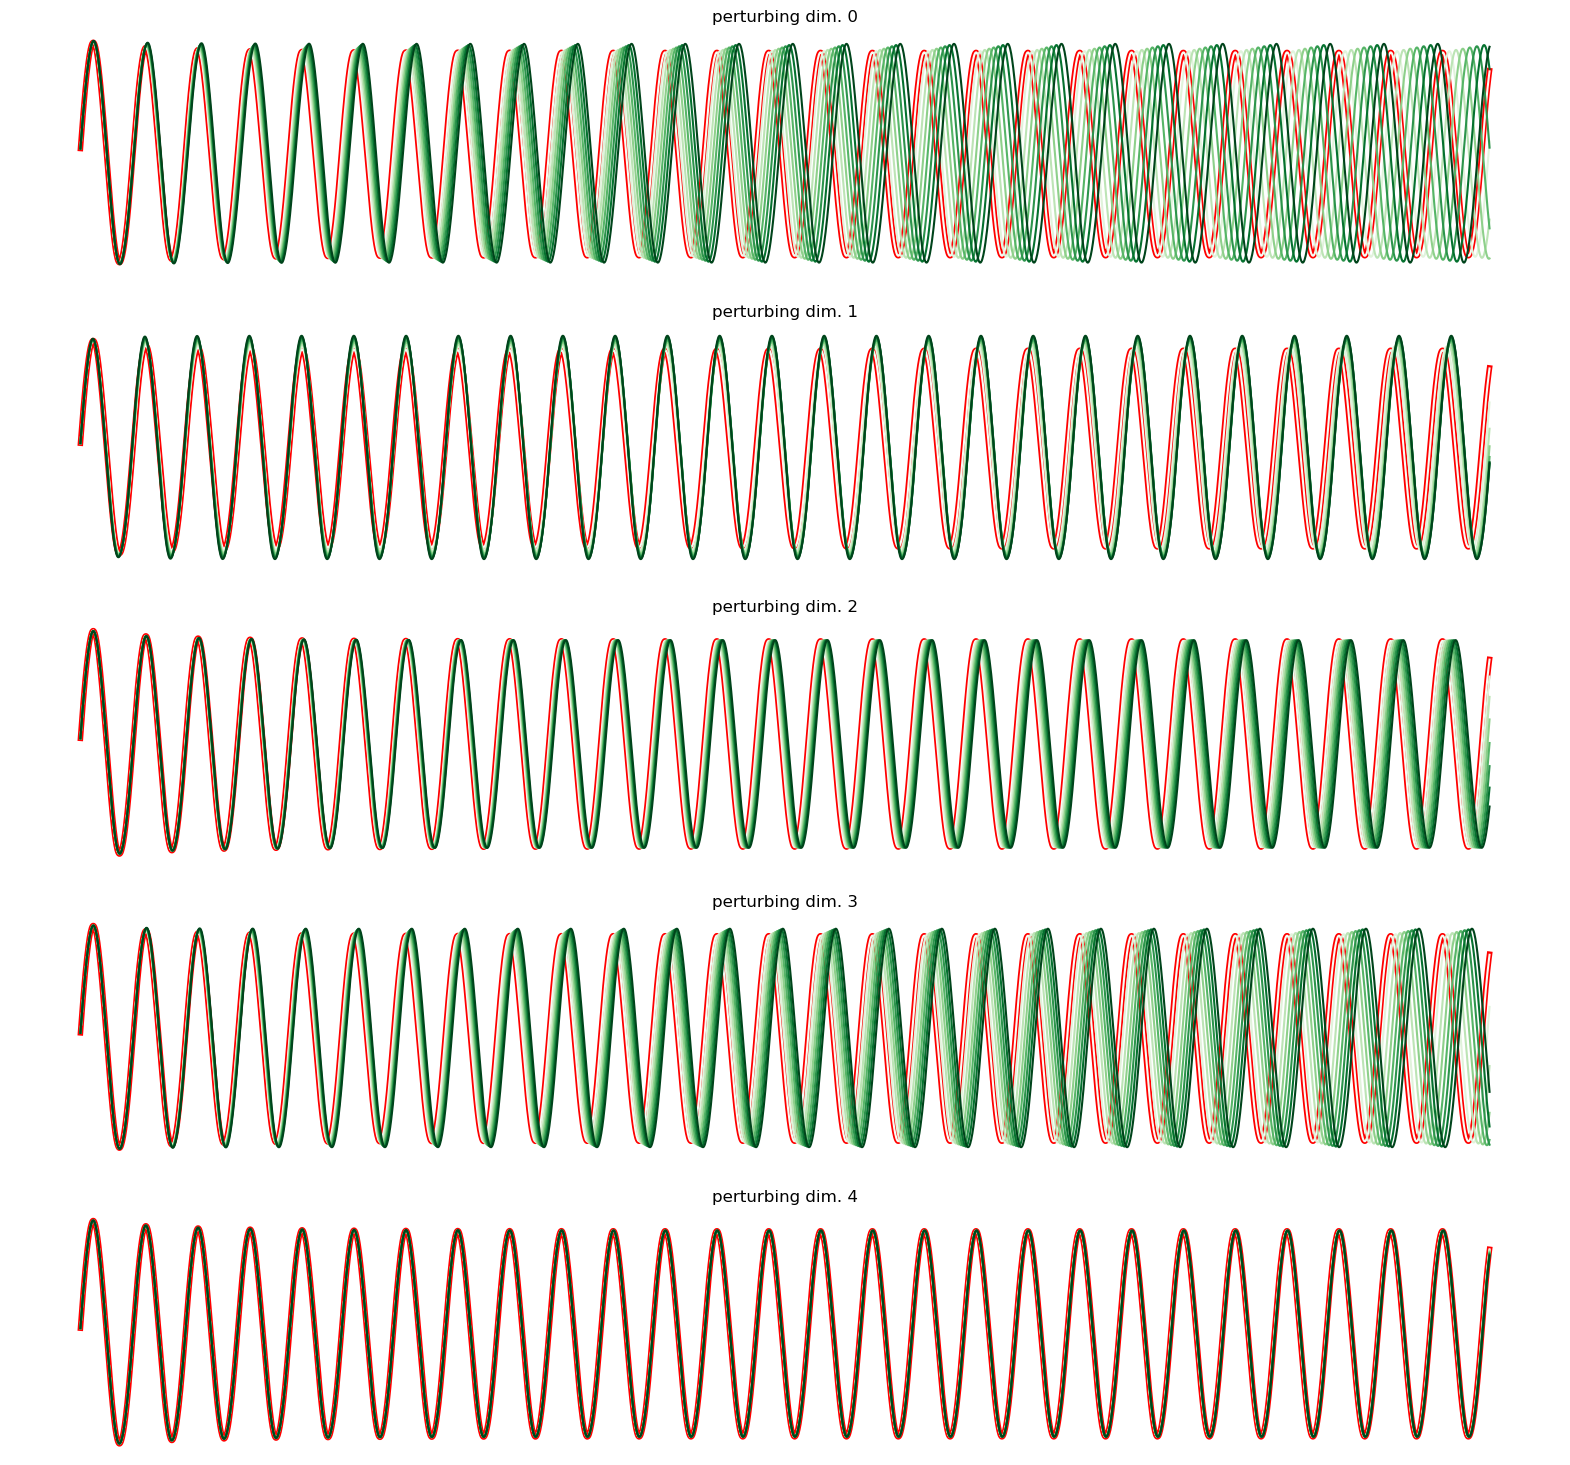

In [625]:
# plot results
plt.figure(figsize = (20,30))

# choose a colormap for the plots
import matplotlib
cmap = matplotlib.colormaps['Greens']
colors = cmap(np.linspace(0,1,numPerts))

# grab original output
_,_,_,originalOutput = returnRates(U,input,B,xStart=xStart,rStart=rStart,zStart=zStart)

for ii in range(numDims):

    plt.subplot(numPerts,1,ii+1);
    # plot original output
    plt.plot(originalOutput[:,0],'r',linewidth=4)

    # plot all the perturbations
    for jj in range(numPerts):
        plt.plot(allOutputs[:,ii,jj],color=colors[jj,:],linewidth=1.5)

    # add a title
    plt.title('perturbing dim. ' + str(ii))
    plt.axis('off');

In [645]:
# it looks like perturbing 1 dimension at a time is less likely to cause terrible errors
#re-run the experiment from above with perturbations to 1 dimension
# start rates at a time when the network is already in its limit cycle
def runPertExperiment_oneDim(IN,numTrials=1000,pertMag = 1e-3):

    # first get the original (i.e., unperturbed) output
    _,_,_,originalOutput = returnRates(U,IN,B,xStart=xStart,rStart=rStart,zStart=zStart)

    # calculate the original frequency
    oFreq = returnPeakFreq(originalOutput[:,0],)

    # keep track of our perturbations, change in frequency, and MSE
    allPerts = np.zeros((U.shape[0],U.shape[1],numTrials)) + np.nan
    dFreq    = np.zeros(numTrials) + np.nan
    MSE      = np.zeros(numTrials) + np.nan

    # cycle through perturbations
    for ii in range(numTrials):

        # generate a perturbation matrix for U.
        dU = np.zeros(U.shape)
        pert = 2 * np.random.random_sample(size=(1,U.shape[1])) -1

        # normalize
        pert = pert / np.linalg.norm(pert,axis=1)

        # choose a random dimension
        dim = np.random.randint(low=0,high=6)

        # plug in the perturbation
        dU[dim,:] = pert * pertMag

        # save the perturbations
        allPerts[:,:,ii] = np.copy(dU)

        # generate our perturbed U
        U_pert = np.copy(U) + dU

        # generate a perturbed output
        _,_,_,newOutput = returnRates(U_pert,IN,B,xStart=xStart,rStart=rStart,zStart=zStart)

        # calculate the new frequency
        nFreq = returnPeakFreq(newOutput[:,0],0.01)

        # save change in frequency
        dFreq[ii] = oFreq - nFreq

        # calculate MSE
        MSE[ii] = calculateAdjustedMSE(originalOutput[:,0], newOutput[:,0], oFreq, nFreq)

    # return everything
    return allPerts, dFreq, MSE

In [646]:
# run the experiment

# make a longer input
longInput = np.ones((4000,1))
longInput[:200,:] = 0

# run experiment
allPerts, dFreq, MSE = runPertExperiment_oneDim(longInput[startIdx:,:],numTrials=2000,pertMag = 1e-3)

/var/folders/h4/g8hnl8017b358kqbslb6bbx40000gn/T/ipykernel_48192/1895814772.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  freqRatio = fastFreq/slowFreq
/var/folders/h4/g8hnl8017b358kqbslb6bbx40000gn/T/ipykernel_48192/1895814772.py:53: RuntimeWarning: invalid value encountered in multiply
  fastTimes_stretched = np.arange(0,oSignalDur) * freqRatio


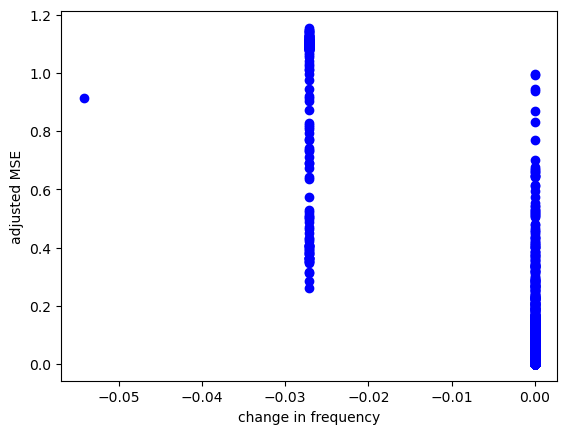

In [647]:
# plot everything
plt.plot(dFreq,MSE,'bo');
plt.xlabel('change in frequency');
plt.ylabel('adjusted MSE');

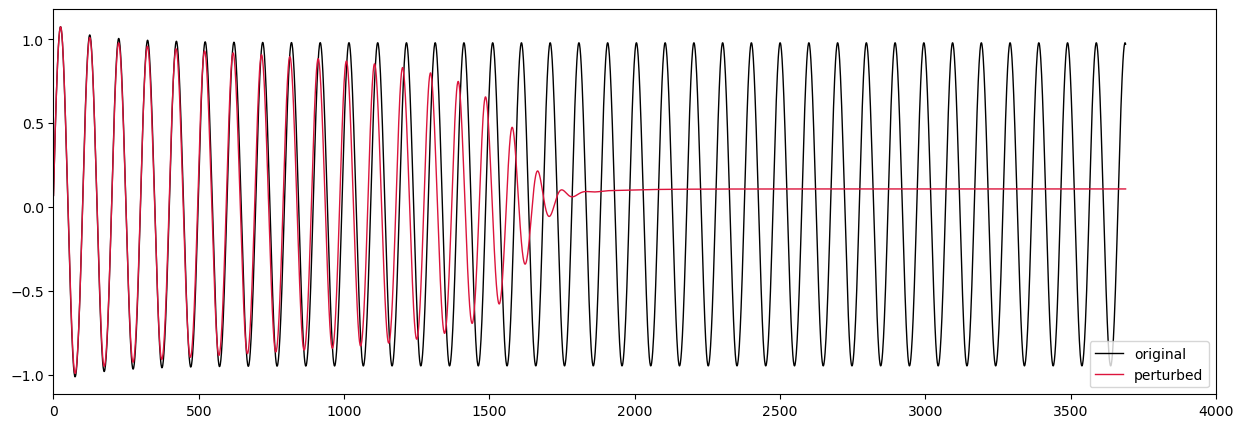

In [707]:
# plot an example perturbation with a large effect and small change in MSE

# original output
_,_,_,originalOutput = returnRates(U,longInput[startIdx:,:],B,xStart=xStart,rStart=rStart,zStart=zStart)

# choose a perturbation
pIdx = np.nonzero((MSE < 0.5) & (dFreq<0))[0][0]

# perturbed output
_,_,_,perturbedOutput = returnRates(U+allPerts[:,:,pIdx],longInput[startIdx:,:],B,xStart=xStart,rStart=rStart,zStart=zStart)

# plot
plt.figure(figsize=(15,5));
plt.plot(originalOutput[:,0],'k',linewidth=1,label='original')
plt.plot(perturbedOutput[:,0],'crimson',linewidth=1,label='perturbed');
plt.legend()
plt.xlim([0,4000]);

### learn to change the frequency of the output from
    - provide a random perturbation to U on each trial
    - If frequency decreases and amplitude doesn't change too much, keep change.


In [1000]:
# function that runs the experiment
def runSingleDirectionLearning(IN,numTrials=10,alpha=1,pertMag=1e-3,ampChangeThreshold = 0.05,targetFreq = 0.75):


    # initialize the U (keep it separate from our original U
    U_learn = np.copy(U)

    # grab the norm of the original U weights
    U_norm = np.linalg.norm(U_learn,axis=1)

    # generate the output for the current U
    _,_,_,originalOutput = returnRates(U_learn,IN,B,xStart=xStart,rStart=rStart,zStart=zStart)

    # current speed
    currentFreq = returnPeakFreq(originalOutput[:,0],minFreq = 0.9, maxFreq = 1.1, numFreqs=100)

    # calculate error between target frequency and current frequency
    error = (targetFreq - currentFreq)**2

    # keep track of our speed in each context
    allError = np.zeros(numTrials)

    # keep track of the amplitude
    allAmp = np.zeros(numTrials)

    # get the amplitude of the current output
    oAmp = np.max(originalOutput[-200:,0])

    # allowed amplitude range (after perturbation)
    maxAmp = oAmp + (oAmp * ampChangeThreshold)
    minAmp = oAmp - (oAmp * ampChangeThreshold)

    # amplitude of current best output
    cAmp = oAmp



    # cycle through trials
    for ii in range(numTrials):

        # generate a perturbation matrix for U.
        dU = 2 * np.random.random_sample(size=U.shape) -1

        # scale each row of U to have a magnitude of 'pertMag'
        dU = (dU.T/ np.linalg.norm(dU,axis=1)).T
        dU = dU * pertMag

        # only perturb the first K-1 dimensions
        dU[-1,:] = 0

        # generate our perturbed U
        U_pert = U_learn + dU

        # re-normalize
        U_pert = (U_pert.T / np.linalg.norm(U_pert,axis=1)).T
        U_pert = U_pert * U_norm[:,np.newaxis]

        # generate a perturbed output
        _,_,_,newOutput = returnRates(U_pert,IN,B,xStart=xStart,rStart=rStart,zStart=zStart)

        # calculate the new frequency
        nFreq = returnPeakFreq(newOutput[:,0],minFreq = currentFreq-0.1, maxFreq = currentFreq+0.1)

        # calculate new error
        nError = (nFreq - targetFreq)**2

        # check that our amplitude hasn't changed too much
        pertAmp = np.max(newOutput[-200:,0])

        # incorporate the change if things got better
        if (nError < error) & (minAmp <= pertAmp <= maxAmp):
            U_learn = np.copy(U_pert)
            error = nError
            currentFreq = np.copy(nFreq)
            cAmp = pertAmp

        # save our error
        allError[ii] = error
        allAmp[ii] = cAmp

    # return error and our learned U
    return U_learn,allError,allAmp

freq 0: 1.0434343434343436
freq 1: 0.7501672240802675


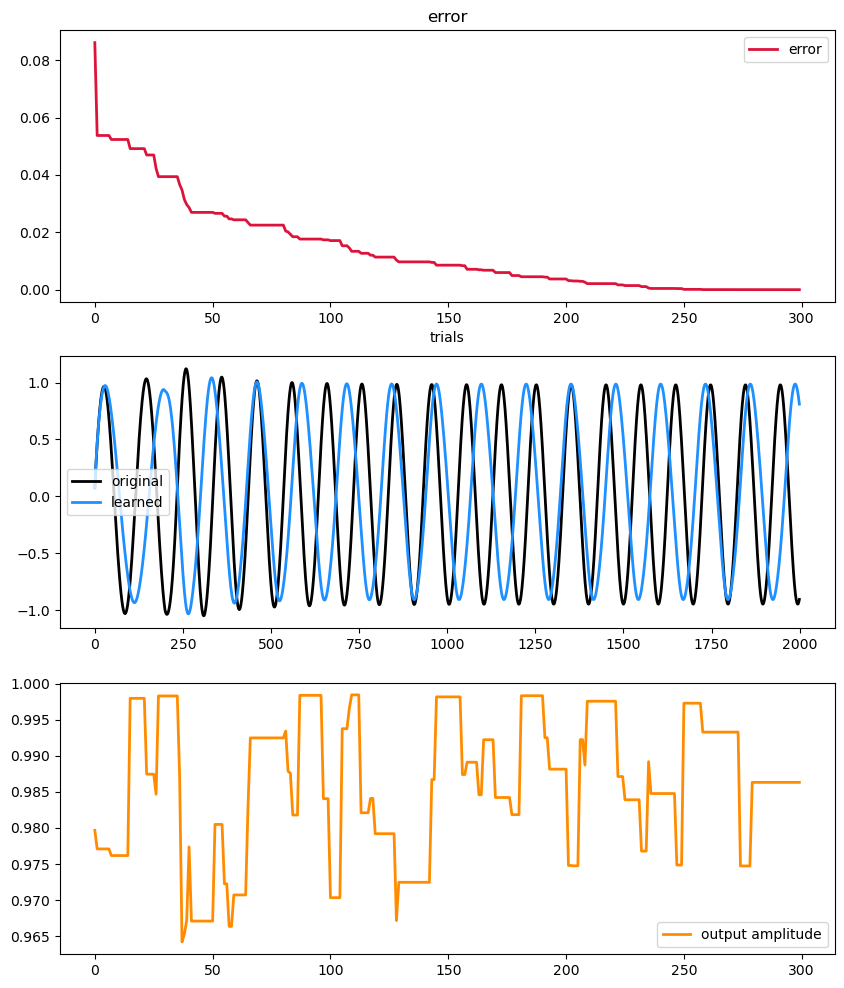

In [1003]:
# run the experiment

# define an input
Input = np.ones((2000,1))
Input[:200,:] = 0


# run the experiment
U_learn,allError,allAmp = runSingleDirectionLearning(Input,numTrials=300,alpha=1,pertMag=1e-3,ampChangeThreshold = 0.02,targetFreq = 0.75)

# plot results
_,_,_,out0 = returnRates(U,Input,B,xStart = xStart, rStart=rStart, zStart=zStart)
_,_,_,out1 = returnRates(U_learn,Input,B,xStart = xStart, rStart=rStart, zStart=zStart)

# calculate final speeds
freq0 = returnPeakFreq(out0[:,0],minFreq = 0.9, maxFreq = 1.1)
freq1 = returnPeakFreq(out1[:,0],minFreq = 0.7, maxFreq = 1.0, numFreqs = 300)

print('freq 0: ' + str(freq0))
print('freq 1: ' + str(freq1))

# plot error
plt.figure(figsize=(10,12))
plt.subplot(3,1,1);
plt.plot(allError,'crimson',linewidth=2,label='error')
plt.title('error')
plt.xlabel('trials')
plt.legend()

# plot output
plt.subplot(3,1,2)

# plot outputs
plt.plot(out0[:,0],'k',linewidth=2,label='original')
plt.plot(out1[:,0],'dodgerblue',linewidth=2,label='learned')
plt.legend()

# plot amplitude of output
plt.subplot(3,1,3)

# plot outputs
plt.plot(allAmp,'darkorange',linewidth=2,label='output amplitude')
plt.legend()



freq 0: 1.0434343434343436
freq 1: 1.2498327759197325


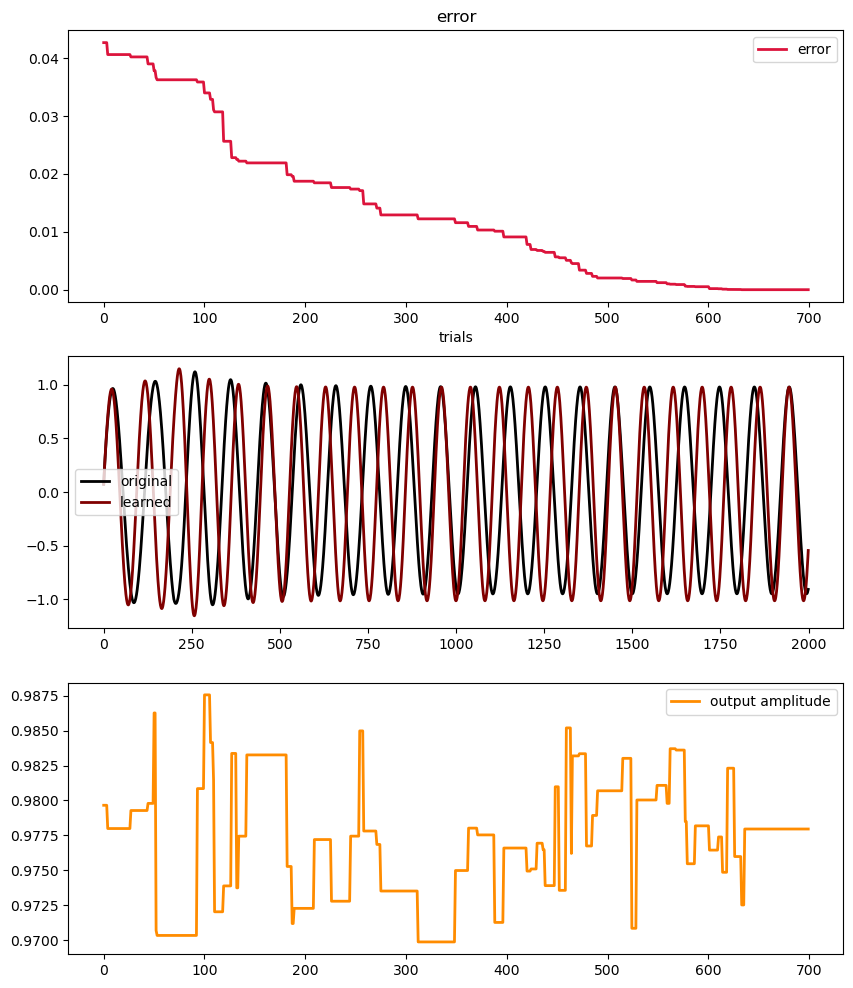

In [1007]:
# Same experiment, but speed up instead of slowing down

# define an input
Input = np.ones((2000,1))
Input[:200,:] = 0


# run the experiment
U_learn,allError,allAmp = runSingleDirectionLearning(Input,numTrials=700,alpha=1,pertMag=1e-3,ampChangeThreshold = 0.01,targetFreq = 1.25)

# plot results
_,_,_,out0 = returnRates(U,Input,B,xStart = xStart, rStart=rStart, zStart=zStart)
_,_,_,out1 = returnRates(U_learn,Input,B,xStart = xStart, rStart=rStart, zStart=zStart)

# calculate final speeds
freq0 = returnPeakFreq(out0[:,0],minFreq = 0.9, maxFreq = 1.1)
freq1 = returnPeakFreq(out1[:,0],minFreq = 1.0, maxFreq = 1.3, numFreqs = 300)

print('freq 0: ' + str(freq0))
print('freq 1: ' + str(freq1))

# plot error
plt.figure(figsize=(10,12))
plt.subplot(3,1,1);
plt.plot(allError,'crimson',linewidth=2,label='error')
plt.title('error')
plt.xlabel('trials')
plt.legend()

# plot output
plt.subplot(3,1,2)

# plot outputs
plt.plot(out0[:,0],'k',linewidth=2,label='original')
plt.plot(out1[:,0],'maroon',linewidth=2,label='learned')
plt.legend()

# plot amplitude of output
plt.subplot(3,1,3)

# plot outputs
plt.plot(allAmp,'darkorange',linewidth=2,label='output amplitude')
plt.legend();

### Learn two different 'skills'
    - In one context, the frequency (of the output) should increase, in a second, frequency of the output should decrease
    - On each trial, the network gets a context signal (+0.5 or 0.5) and a perturbation to U (random)
    - If the frequency speeds up in context 1 OR the frequency slows down in context 2, the perturbation gets incorporated into U.
    - Importantly, there is only 1 U. We're not learning two different inputs.

In [1088]:
def runDuelLearning(IN,numTrials=10,alpha=1,pertMag=1e-3,ampChangeThreshold = 0.05,targetFreq = None):


    # magnitude of the context signals
    contextMags = [-1,1]

    # two target frequencies: one for the slow context, one for the fast
    if targetFreq is None:
        targetFreq = [0.75,1.25]

    # initialize the U (keep it separate from our original U
    U_learn = np.copy(U)

    # grab the norm of the original U weights
    U_norm = np.linalg.norm(U_learn,axis=1)

    # generate the output for the current U
    _,_,_,originalOutput = returnRates(U_learn,IN,B,xStart=xStart,rStart=rStart,zStart=zStart)

    # current speed (keep two current speeds. One for the slow context and one for the fast context)
    currentFreq = returnPeakFreq(originalOutput[:,0],minFreq = 0.9, maxFreq = 1.1, numFreqs=100)
    currentFreq = [currentFreq,currentFreq]

    # calculate error between target frequency and current frequency
    error = [(targetFreq[x] - currentFreq[x])**2 for x in range(2)]

    # keep track of our speed in each context
    allError = np.zeros((numTrials,2))

    # keep track of the amplitude
    allAmp = np.zeros((numTrials,2))

    # get the amplitude of the current output
    oAmp = np.max(originalOutput[-200:,0])

    # allowed amplitude range (after perturbation)
    maxAmp = oAmp + (oAmp * ampChangeThreshold)
    minAmp = oAmp - (oAmp * ampChangeThreshold)

    # amplitude of current best output
    cAmp = oAmp
    cAmp = [cAmp,cAmp]

    # cycle through trials
    for ii in range(numTrials):

        # each context gets seen on each trial
        for jj in range(2):

            # generate a perturbation matrix for U.
            dU = 2 * np.random.random_sample(size=U.shape) -1

            # scale each row of U to have a magnitude of 'pertMag'
            dU = (dU.T/ np.linalg.norm(dU,axis=1)).T
            dU = dU * pertMag

            # only perturb the first K-1 dimensions
            dU[-1,:] = 0

            # generate our perturbed U
            U_pert = U_learn + dU

            # re-normalize
            U_pert = (U_pert.T / np.linalg.norm(U_pert,axis=1)).T
            U_pert = U_pert * U_norm[:,np.newaxis]

            # generate a perturbed output
            _,_,_,newOutput = returnRates(U_pert,IN,B,ctxMag = contextMags[jj],xStart=xStart,rStart=rStart,zStart=zStart)

            # calculate the new frequency
            nFreq = returnPeakFreq(newOutput[:,0],minFreq = currentFreq[jj]-0.1, maxFreq = currentFreq[jj]+0.1)

            # calculate new error
            nError = (nFreq - targetFreq[jj])**2

            # check that our amplitude hasn't changed too much
            pertAmp = np.max(newOutput[-200:,0])

            # incorporate the change if things got better
            if (nError < error[jj]) & (minAmp <= pertAmp <= maxAmp):
                U_learn = np.copy(U_pert)
                error[jj] = nError
                currentFreq[jj] = np.copy(nFreq)
                cAmp[jj] = pertAmp

            # save our error
            allError[ii,jj] = error[jj]
            allAmp[ii,jj] = cAmp[jj]

    # return error and our learned U
    return U_learn,allError,allAmp


freq 1: 0.7496993987975952
freq 2: 0.7208416833667334


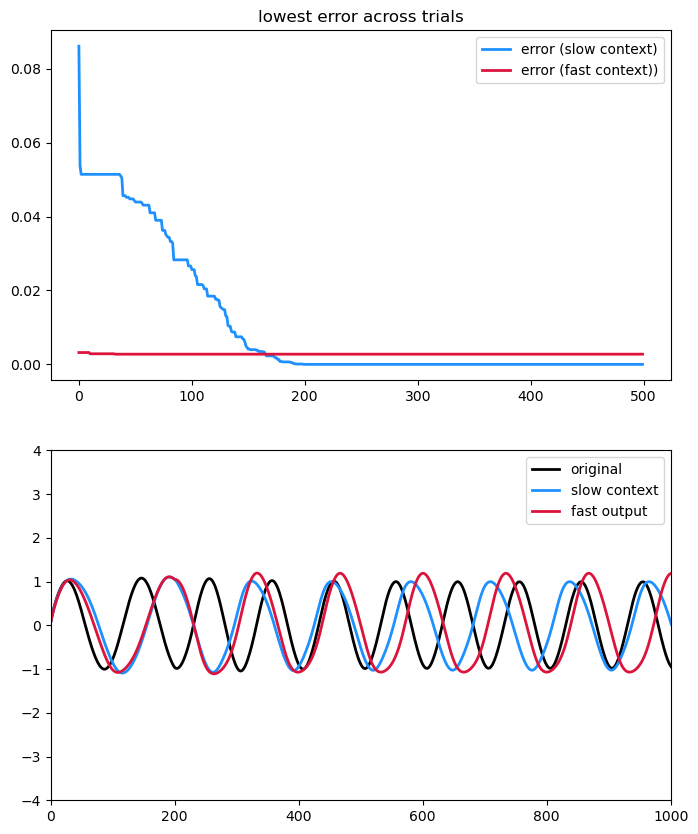

In [1090]:
# run the learning experiment

# generate an input
Input = np.ones((2000,1))
Input[:200,:] = 0

# run experiment
U_learn,allError,allAmp = runDuelLearning(Input,numTrials=500,alpha=1,pertMag=1e-3,ampChangeThreshold = 0.02,targetFreq = [0.75,1.1])

# generate the speeds with the two contexts
_,_,_,outO = returnRates(U,Input,B,ctxMag=-0.5,xStart=xStart,rStart=rStart,zStart=zStart)
_,_,_,out1 =  returnRates(U_learn,Input,B,ctxMag = -1,xStart=xStart,rStart=rStart,zStart=zStart)
_,_,_,out2 =  returnRates(U_learn,Input,B,ctxMag = 1,xStart=xStart,rStart=rStart,zStart=zStart)

# calculate final speeds
freq1 = returnPeakFreq(out1[:,0],minFreq = 0.7, maxFreq = 1.5,numFreqs=500)
freq2 = returnPeakFreq(out2[:,0],minFreq = 0.7, maxFreq = 1.5,numFreqs=500)

print('freq 1: ' + str(freq1))
print('freq 2: ' + str(freq2))


## plot results ##
# plot best speed
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(allError[:,0],'dodgerblue',linewidth=2,label='error (slow context)')
plt.plot(allError[:,1],'crimson',linewidth=2,label='error (fast context))');
plt.title('lowest error across trials')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(outO[:,0],'k',linewidth=2,label='original')

# plot slow context output
plt.plot(out1[:,0],'dodgerblue',linewidth=2,label='slow context')

# plot fast context output
plt.plot(out2[:,0],'crimson',linewidth=2,label='fast output')
plt.ylim([-4,4]);
plt.xlim([0,1000]);
plt.legend();




In [1082]:
_,rates1,lat1,out1 =  returnRates(U_learn,Input,B,ctxMag = -1,xStart=xStart,rStart=rStart,zStart=zStart)
_,rates2,lat2,out2 =  returnRates(U_learn,Input,B,ctxMag = 1,xStart=xStart,rStart=rStart,zStart=zStart)

# calculate final speeds
freq1 = returnPeakFreq(out1[:,0],minFreq = 0.7, maxFreq = 1.5,numFreqs=500)
freq2 = returnPeakFreq(out2[:,0],minFreq = 0.7, maxFreq = 1.5,numFreqs=300)

print('freq 1: ' + str(freq1))
print('freq 2: ' + str(freq2))

freq 1: 0.7496993987975952
freq 2: 0.7240802675585284
